# End to end graph generation demo (CORA)

## Overview

In this notebook, we have walked through the complete process of generating a synthetic dataset based on a CORA dataset. The CORA dataset consists of scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary, so we can interpret the CORA dataset as a graph with categorical node features.

Content:

1. [Prepare the original dataset](#1)
1. [Preprare SynGen Configuration](#2)
1. [Dataset Generation](#3)
1. [Tabular data evaluation](#4)
1. [Structure evaluation](#5)

### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets import CORAPreprocessing

# config
from syngen.configuration import SynGenConfiguration

# generation
from syngen.synthesizer import ConfigurationGraphSynthesizer

# evaluation
from syngen.analyzer.tabular import TabularMetrics
from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.stats import get_dd_simmilarity_score
from syngen.analyzer.graph.analyser import AnalysisModule

# utils
import copy
from syngen.utils.types import MetaData

<a id="1"></a>
## Prepare original dataset

SynGen requires the data to be in SynGen dataset format or simply SynGen format, so firstly, we transform the raw Cora dataset into SynGen format. If you don't download Cora before, you may pass `download=True` as `CoraPreprocessing` class supports automatic downloading.

In [2]:
data_path = '/workspace/data/cora'
preprocessed_path = '/workspace/data/cora_preprocessed'

In [3]:
preprocessing = CORAPreprocessing(source_path=data_path, destination_path=preprocessed_path, download=False)

In [4]:
feature_spec_original = preprocessing.transform(use_cache=True)

In [5]:
feature_spec_original

{'nodes': [{'name': 'paper',
   'count': 2708,
   'features': [{'name': 'w_0',
     'dtype': 'int64',
     'feature_type': 'categorical'},
    {'name': 'w_1', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_2', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_3', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_4', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_5', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_6', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_7', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_8', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_9', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_10', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_11', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_12', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_13

<a id="2"></a>
## Preprare SynGen Configuration

SynGen generation process is driven by the configuration that is the superset of the SynGen format metadata file. Let us create two configurations: a proper one that will mimic Cora dataset tabular and structural features and a random one.

### Proper Synthetic 

In [6]:
feature_spec_synthetic = feature_spec_original.copy()

feature_spec_synthetic[MetaData.NODES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "kde",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'configuration',
            MetaData.PATH: preprocessed_path,
            MetaData.NAME: "paper",
        },
        MetaData.PARAMS: {
        }
    }
]

feature_spec_synthetic[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'cfg', # the same a 'configuration'
        MetaData.PATH: preprocessed_path,
        MetaData.NAME: "cite",
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

# aligns 'label' node feature based on the 'cite' edges
feature_spec_synthetic[MetaData.ALIGNERS] = [
    {
        MetaData.TYPE: "xgboost",
        MetaData.GRAPHS: ['cite'],
        MetaData.NODES: {"paper": ["label"]},
        MetaData.EDGES: {},
        MetaData.PARAMS: {},
    }
]

config_proper = SynGenConfiguration(feature_spec_synthetic)

In [7]:
config_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'cite',
   'count': 5428,
   'src_node_type': 'paper',
   'dst_node_type': 'paper',
   'directed': False,
   'features': [],
   'features_path': None,
   'structure_path': 'cite_edge_list.parquet',
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'cfg',
     <MetaData.PATH: 'path'>: '/workspace/data/cora_preprocessed',
     <MetaData.NAME: 'name'>: 'cite'},
    <MetaData.PARAMS: 'params'>: {'has_self_loop': False}}}],
 <MetaData.NODES: 'nodes'>: [{'name': 'paper',
   'count': 2708,
   'features': [{'name': 'w_0',
     'dtype': 'int64',
     'feature_type': 'categorical'},
    {'name': 'w_1', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_2', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_3', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_4', 'dtype': 'int64', 'feature_type': 'c

### Random 

In [8]:
feature_spec_random = feature_spec_original.copy() 

feature_spec_random[MetaData.NODES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "random",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'random',
        },
        MetaData.PARAMS: {
        }
    }
]

feature_spec_random[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'rnd', # the save as 'random' 
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

config_random = SynGenConfiguration(feature_spec_random)

In [9]:
config_random

{<MetaData.EDGES: 'edges'>: [{'name': 'cite',
   'count': 5428,
   'src_node_type': 'paper',
   'dst_node_type': 'paper',
   'directed': False,
   'features': [],
   'features_path': None,
   'structure_path': 'cite_edge_list.parquet',
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'rnd'},
    <MetaData.PARAMS: 'params'>: {'has_self_loop': False}}}],
 <MetaData.NODES: 'nodes'>: [{'name': 'paper',
   'count': 2708,
   'features': [{'name': 'w_0',
     'dtype': 'int64',
     'feature_type': 'categorical'},
    {'name': 'w_1', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_2', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_3', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_4', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_5', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_6', '

<a id="3"></a>
## Dataset Generation

In [10]:
save_path_proper = '/workspace/data/cora_generated'
save_path_random = '/workspace/data/cora_random'

### Create Synthesizers

In [11]:
synthesizer_proper = ConfigurationGraphSynthesizer(configuration=config_proper, save_path=save_path_proper, gpu=True)
synthesizer_random = ConfigurationGraphSynthesizer(configuration=config_random, save_path=save_path_random, gpu=True)

### Fit Synthesizers

In [12]:
synthesizer_proper.fit()

In [13]:
synthesizer_random.fit()

### Generation

In [14]:
feature_spec_generated_proper = synthesizer_proper.generate()

In [15]:
feature_spec_generated_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'cite',
   'count': 5428,
   'src_node_type': 'paper',
   'dst_node_type': 'paper',
   'directed': False,
   'features': [],
   'features_path': None,
   'structure_path': 'cite_edge_list.parquet',
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'cfg',
     <MetaData.PATH: 'path'>: '/workspace/data/cora_preprocessed',
     <MetaData.NAME: 'name'>: 'cite'},
    <MetaData.PARAMS: 'params'>: {'has_self_loop': False,
     'gpu': True,
     'verbose': False}}}],
 <MetaData.NODES: 'nodes'>: [{'name': 'paper',
   'count': 4096,
   'features': [{'name': 'w_0',
     'dtype': 'int64',
     'feature_type': 'categorical'},
    {'name': 'w_1', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_2', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_3', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w

In [16]:
feature_spec_generated_random = synthesizer_random.generate()

In [17]:
feature_spec_generated_random

{<MetaData.EDGES: 'edges'>: [{'name': 'cite',
   'count': 5428,
   'src_node_type': 'paper',
   'dst_node_type': 'paper',
   'directed': False,
   'features': [],
   'features_path': None,
   'structure_path': 'cite_edge_list.parquet',
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'rnd'},
    <MetaData.PARAMS: 'params'>: {'has_self_loop': False,
     'gpu': True,
     'verbose': False}}}],
 <MetaData.NODES: 'nodes'>: [{'name': 'paper',
   'count': 4095,
   'features': [{'name': 'w_0',
     'dtype': 'int64',
     'feature_type': 'categorical'},
    {'name': 'w_1', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_2', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_3', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_4', 'dtype': 'int64', 'feature_type': 'categorical'},
    {'name': 'w_5', 'dtype': 'int64', 'feature_typ

<a id="4"></a>
## Tabular Data Evaluation

In [18]:
original_tabular_data, categorical_features = feature_spec_original.get_tabular_data(MetaData.NODES, 'paper', return_cat_feats=True)

In [19]:
proper_tabular_data = feature_spec_generated_proper.get_tabular_data(MetaData.NODES, 'paper')

In [20]:
random_tabular_data = feature_spec_generated_random.get_tabular_data(MetaData.NODES, 'paper')

In [21]:
tab_eval = TabularMetrics(original_tabular_data, 
                          proper_tabular_data, 
                          categorical_columns=categorical_features)

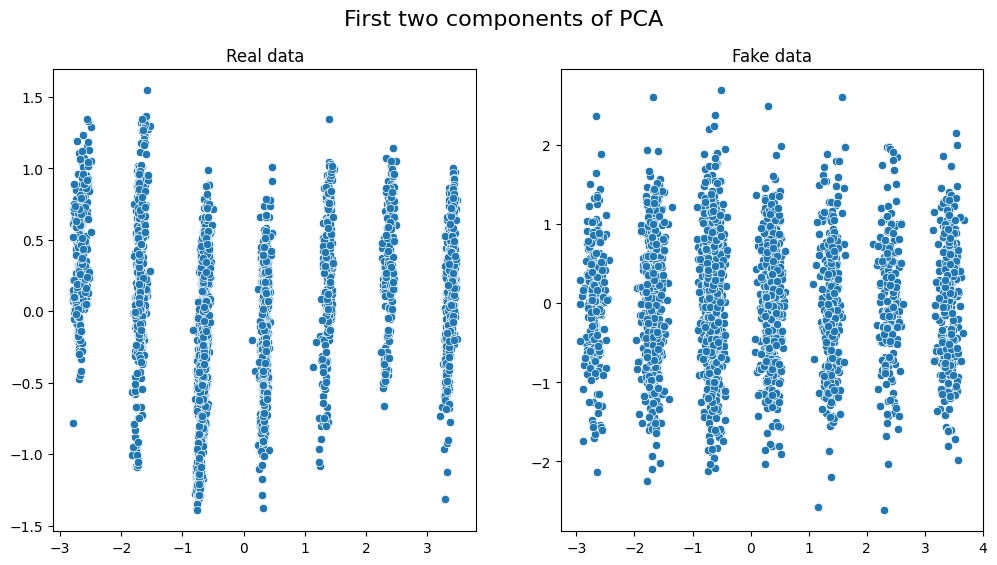

In [22]:
tab_eval.plot_pca()

In [23]:
tab_eval = TabularMetrics(original_tabular_data, 
                          random_tabular_data, 
                          categorical_columns=categorical_features)

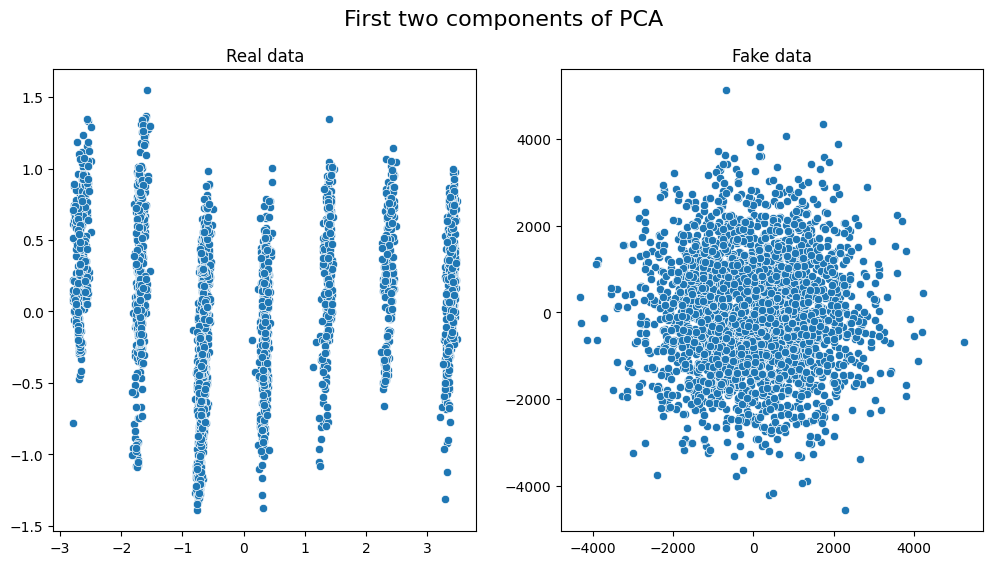

In [24]:
tab_eval.plot_pca()

<a id="5"></a>
## Structute Evaluation

In [25]:
original_graph_structure = feature_spec_original.get_structural_data('cite')
proper_graph_structure = feature_spec_generated_proper.get_structural_data('cite')
random_graph_structure = feature_spec_generated_random.get_structural_data('cite')

In [26]:
orig_proper = get_dd_simmilarity_score(original_graph_structure, proper_graph_structure, cdf_points=1000)
orig_random = get_dd_simmilarity_score(original_graph_structure, random_graph_structure, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.5999224835698596
ORIG vs RANDOM: 0.5943246117058348


In [27]:
original_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_original, 'cite', graph_name='original')
proper_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_generated_proper, 'cite', graph_name='properly_generated')
random_graph_structure = Graph.instantiate_from_feature_spec(feature_spec_generated_random, 'cite', graph_name='randomly_generated')
all_graphs = [original_snap_graph, proper_snap_graph, random_graph_structure]

In [28]:
graph_analyser = AnalysisModule()

In [29]:
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,original,properly_generated,randomly_generated
0,Global stats,Nodes,2708,4096,4095
1,Global stats,Edges,5277,5428,5428
2,Global stats,Density,0.0014,0.0006,0.0006
3,Global stats,Average degree,1.95,1.33,1.33
4,Global stats,Zero deg nodes,0,837,636
5,Global stats,Zero in deg nodes,0,837,636
6,Global stats,Zero out deg nodes,0,837,636
7,Global stats,Self loops,0,0,0
8,Global stats,Bidirectional edges,5277,5428,5428
9,Global stats,Unique undirected edges,5277,5428,5428


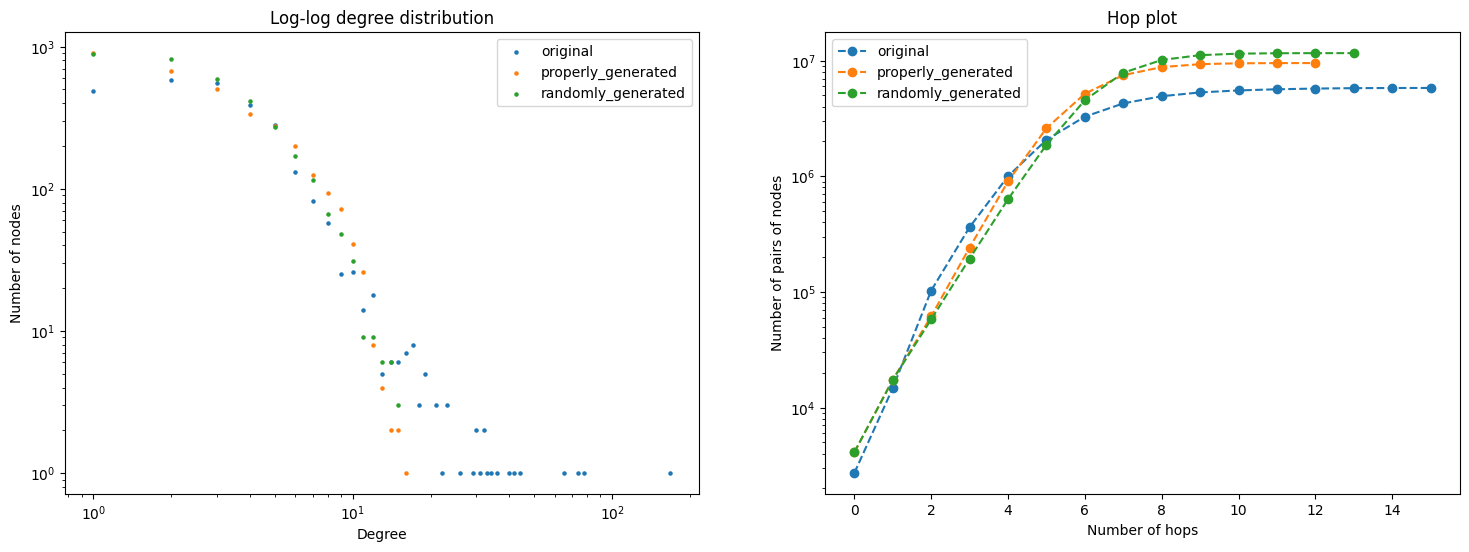

In [30]:
from matplotlib.pyplot import set_loglevel
set_loglevel('warning')
_ = graph_analyser.compare_graph_plots(*all_graphs)